In [ ]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.transforms import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from pytube import YouTube

In [ ]:
!pip install yt_dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.3 MB/s eta 0:00:00


### Downloading video using yt_dlp

In [ ]:
import yt_dlp

def download_video(url, output_path='.'):
    """
    Download YouTube video using yt-dlp
    """
    ydl_opts = {
        'format': 'best',
        'outtmpl': f'{output_path}/%(title)s.%(ext)s',
        'quiet': False,
        'progress': True,
        'no_warnings': True
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            print("Starting download...")
            info = ydl.extract_info(url, download=True)
            video_path = ydl.prepare_filename(info)
            print(f"Downloaded: {video_path}")
            return video_path
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

url = "https://www.youtube.com/watch?v=l3NJNFmg09k"
video = download_video(url, "/content/")

Starting download...
[youtube] Extracting URL: https://www.youtube.com/watch?v=l3NJNFmg09k
[youtube] l3NJNFmg09k: Downloading webpage
[youtube] l3NJNFmg09k: Downloading ios player API JSON
[youtube] l3NJNFmg09k: Downloading mweb player API JSON
[youtube] l3NJNFmg09k: Downloading player 0ccfa671
[youtube] l3NJNFmg09k: Downloading m3u8 information
[info] l3NJNFmg09k: Downloading 1 format(s): 18
[download] Destination: /content//Football match.mp4
[download] 100% of    3.57MiB in 00:00:01 at 2.81MiB/s   
Downloaded: /content//Football match.mp4


### Fast RCNN

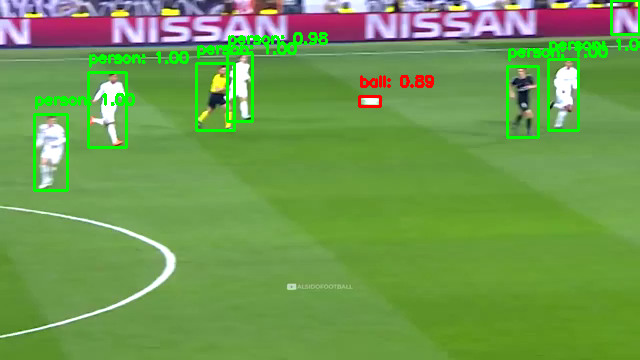

KeyboardInterrupt: 

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from PIL import Image
from google.colab.patches import cv2_imshow

# Load model with COCO weights
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn(weights=weights)
model.eval()

# Get preprocessing transformation
preprocess = weights.transforms()


def process_frame(frame):
    # Convert BGR to RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert to PIL Image
    pil_image = Image.fromarray(rgb_frame)

    # Preprocess using COCO weights transform
    input_tensor = preprocess(pil_image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        prediction = model(input_batch)[0]

    # Filter person (1) and sports ball (37)
    mask = (prediction['labels'] == 1) | (prediction['labels'] == 37)
    boxes = prediction['boxes'][mask]
    labels = prediction['labels'][mask]
    scores = prediction['scores'][mask]

    return boxes, labels, scores

def visualize_detections(frame, boxes, labels, scores, threshold=0.7):
    img = frame.copy()

    # Filter by confidence
    mask = scores > threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box.int().numpy()
        # Green for person, red for ball
        color = (0, 255, 0) if label == 1 else (0, 0, 255)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # Add label and score
        text = f'{"person" if label == 1 else "ball"}: {score:.2f}'
        cv2.putText(img, text, (x1, y1-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

def process_video(input_path, output_path):
    # Open video
    cap = cv2.VideoCapture(input_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter object
    out = cv2.VideoWriter(output_path,
                         cv2.VideoWriter_fourcc(*'mp4v'),
                         fps,
                         (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process frame
        boxes, labels, scores = process_frame(frame)
        result_frame = visualize_detections(frame, boxes, labels, scores)

        # Write frame
        out.write(result_frame)

        # Display frame
        cv2_imshow(result_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # cv2_imshow(result_frame)
    cap.release()
    out.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":

    input_video = "/content//Football match.mp4"
    output_video = "/content//output.mp4"
    process_video(input_video, output_video)

    cap = cv2.VideoCapture(input_video)
    ret, frame = cap.read()
    if ret:
        boxes, labels, scores = process_frame(frame)
        result = visualize_detections(frame, boxes, labels, scores)

        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    cap.release()

### Task-2: DeepSort

In [ ]:
!pip install torch torchvision yolov5 deep-sort-realtime opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.5/953.5 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.0/887.0 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.4 MB/s eta 0:00:00
  Cr

In [ ]:
from deep_sort_realtime.deepsort_tracker import DeepSort
import torch

class ObjectDetector:
    def __init__(self, model_path='yolov5s.pt', conf_threshold=0.3):
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
        self.model.conf = conf_threshold

    def detect(self, frame):
        results = self.model(frame)
        detections = []

        # List of possible ball-related classes in YOLOv5
        ball_classes = ['sports ball', 'ball', 'soccer ball']

        for *xyxy, conf, cls in results.xyxy[0]:
            class_name = results.names[int(cls)]

            # Classify as 'ball' if it matches any ball-related class
            if any(ball_class in class_name.lower() for ball_class in ball_classes):
                class_name = 'ball'

            if class_name in ['person', 'ball']:
                x1, y1, x2, y2 = map(float, xyxy)
                detection = {
                    'bbox': [x1, y1, x2-x1, y2-y1],
                    'score': float(conf),
                    'class': class_name
                }
                detections.append(detection)

        return detections


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
import torch

def process_frame(frame, detector, tracker):
    detections = detector.detect(frame)
    detection_list = []
    classes = []

    for det in detections:
        bbox = det['bbox']
        detection_list.append((
            [bbox[0], bbox[1], bbox[2], bbox[3]],
            det['score']
        ))
        classes.append(det['class'])

    tracks = tracker.update_tracks(detection_list, frame=frame)
    return tracks, classes

def process_and_save_video(input_path, output_path):
    detector = ObjectDetector(model_path='yolov5s.pt', conf_threshold=0.3)
    tracker = DeepSort(max_age=5)
    track_classes = {}

    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        tracks, classes = process_frame(frame, detector, tracker)

        # Update track classes with new detections
        for track, cls in zip(tracks, classes):
            if track.is_confirmed():
                track_classes[track.track_id] = cls

        for track in tracks:
            if not track.is_confirmed():
                continue

            ltrb = track.to_ltrb()
            class_name = track_classes.get(track.track_id, 'person')  # Default to person

            color = (0, 255, 0) if class_name == 'person' else (0, 0, 255)  # Green for person, Red for ball

            cv2.rectangle(frame,
                         (int(ltrb[0]), int(ltrb[1])),
                         (int(ltrb[2]), int(ltrb[3])),
                         color, 1)

            label = f"{class_name}-{track.track_id}"
            cv2.putText(frame, label,
                       (int(ltrb[0]), int(ltrb[1]-5)),
                       cv2.FONT_HERSHEY_SIMPLEX,
                       0.5,
                       color,
                       1)

        out.write(frame)
        cv2_imshow( frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()



# Run the processing
if __name__ == "__main__":
    process_and_save_video('/content//Football match.mp4', 'output_ds.mp4')


### Architecture of the tracking solution

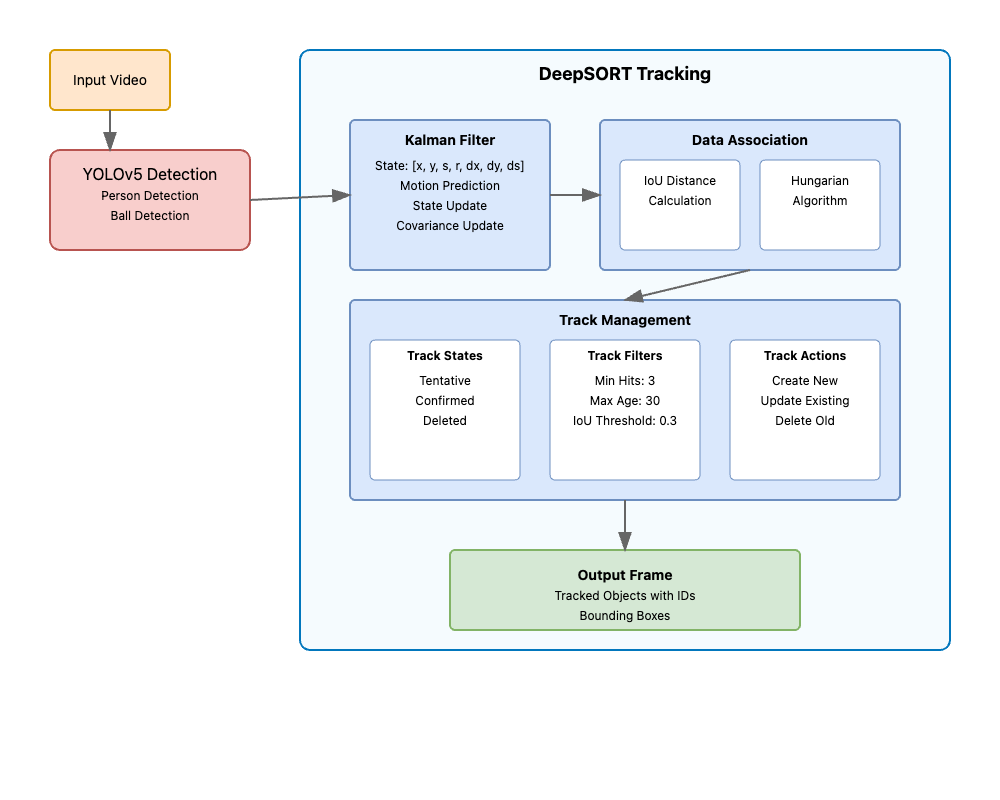

## Kalman Filter

**State Vector x**: [x, y, s, r, ẋ, ẏ, ṡ] - Represents object position, scale, aspect ratio and their velocities

**Prediction**:
x̂(k|k-1) = Fx̂(k-1|k-1) - Projects state ahead using motion model

P(k|k-1) = FP(k-1|k-1)F' + Q - Projects uncertainty ahead with process noise

**Update**:
y = z - Hx̂(k|k-1) - Computes measurement residual

S = HP(k|k-1)H' + R - Projects uncertainty into measurement space

K = P(k|k-1)H'S⁻¹ - Optimal Kalman gain minimizing estimate uncertainty

x̂(k|k) = x̂(k|k-1) + Ky - Updates state estimate with measurement

P(k|k) = (I - KH)P(k|k-1) - Updates estimate uncertainty

## Hungarian Algorithm

**Cost Matrix**: C[i,j] = 1 - IoU(track_i, detection_j) - Defines assignment costs between tracks and detections

**IoU**: area_of_intersection / area_of_union - Measures overlap between bounding boxes

**Assignment**: min ∑ᵢⱼ C[i,j]x[i,j] - Minimizes total assignment cost while ensuring one-to-one matching

## Track Management

**Parameters**:
- Min Hits (3): Required detections to confirm track

- Max Age (30): Maximum frames without detection before deletion
- IoU Threshold (0.3): Minimum overlap required for track-detection association